In [1]:
# Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
file_path = 'marketing_campaign.csv'
df = pd.read_csv(file_path, sep='\t')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


## Data Preprocessing

In [3]:
# Convert Dt_Customer to datetime format
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], errors='coerce')

# Convert data types for Income and Year_Birth
df['Income'] = pd.to_numeric(df['Income'], errors='coerce')  # Ensure Income is a float
df['Year_Birth'] = pd.to_numeric(df['Year_Birth'], errors='coerce')  # Ensure Year_Birth is an integer

# Remove Year_Birth outliers (before 1900) and cap Income at the 99th percentile
df_cleaned = df[df['Year_Birth'] >= 1900]
income_cap = df_cleaned['Income'].quantile(0.99)
df_cleaned['Income'] = df_cleaned['Income'].apply(lambda x: min(x, income_cap))

# Creating TotalSpending and Age features
df_cleaned['TotalSpending'] = df_cleaned[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)
df_cleaned['Age'] = 2024 - df_cleaned['Year_Birth']

# Display the cleaned dataset with new features
df_cleaned[['Income', 'TotalSpending', 'Age']].head()

/var/folders/n3/wq3qj7vn3c12xjhrsq0nrmcr0000gn/T/ipykernel_16720/2970930863.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], errors='coerce')
/var/folders/n3/wq3qj7vn3c12xjhrsq0nrmcr0000gn/T/ipykernel_16720/2970930863.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Income'] = df_cleaned['Income'].apply(lambda x: min(x, income_cap))
/var/folders/n3/wq3qj7vn3c12xjhrsq0nrmcr0000gn/T/ipykernel_16720/2970930863.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

,Income,TotalSpending,Age
0,58138.0,1617,67
1,46344.0,27,70
2,71613.0,776,59
3,26646.0,53,40
4,58293.0,422,43


## Customer Demographics Analysis

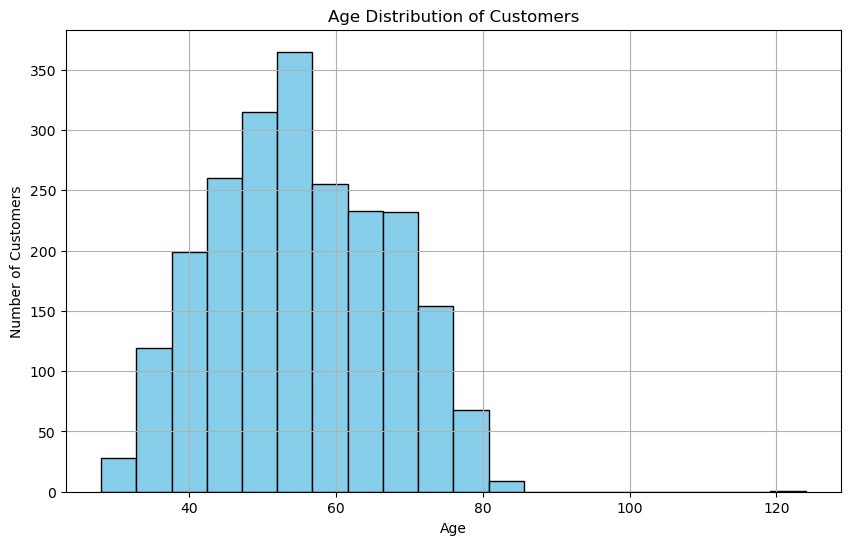

In [4]:
# Age distribution
plt.figure(figsize=(10, 6))
plt.hist(df_cleaned['Age'], bins=20, color='skyblue', edgecolor='black')
plt.title('Age Distribution of Customers')
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.grid(True)
plt.show()

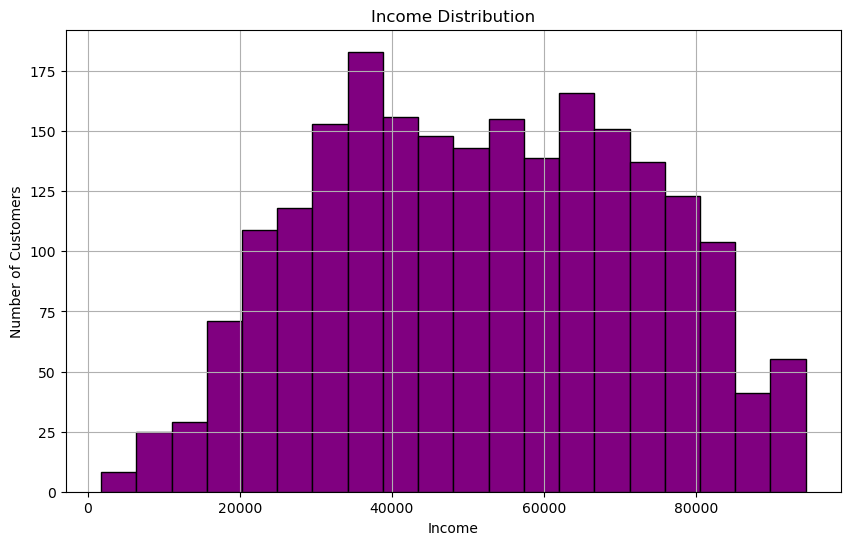

In [5]:
# Income distribution
plt.figure(figsize=(10, 6))
plt.hist(df_cleaned['Income'], bins=20, color='purple', edgecolor='black')
plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('Number of Customers')
plt.grid(True)
plt.show()

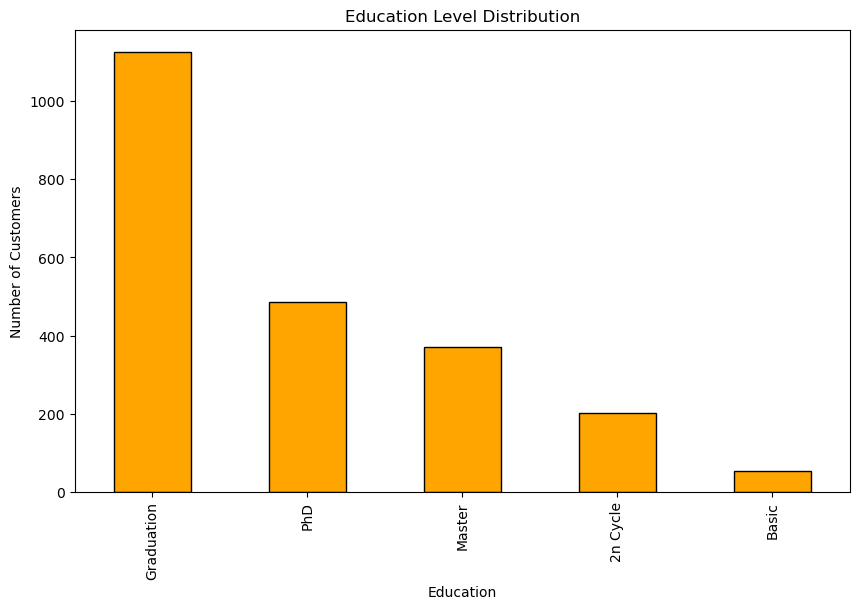

In [6]:
# Education level distribution
plt.figure(figsize=(10, 6))
df_cleaned['Education'].value_counts().plot(kind='bar', color='orange', edgecolor='black')
plt.title('Education Level Distribution')
plt.xlabel('Education')
plt.ylabel('Number of Customers')
plt.show()

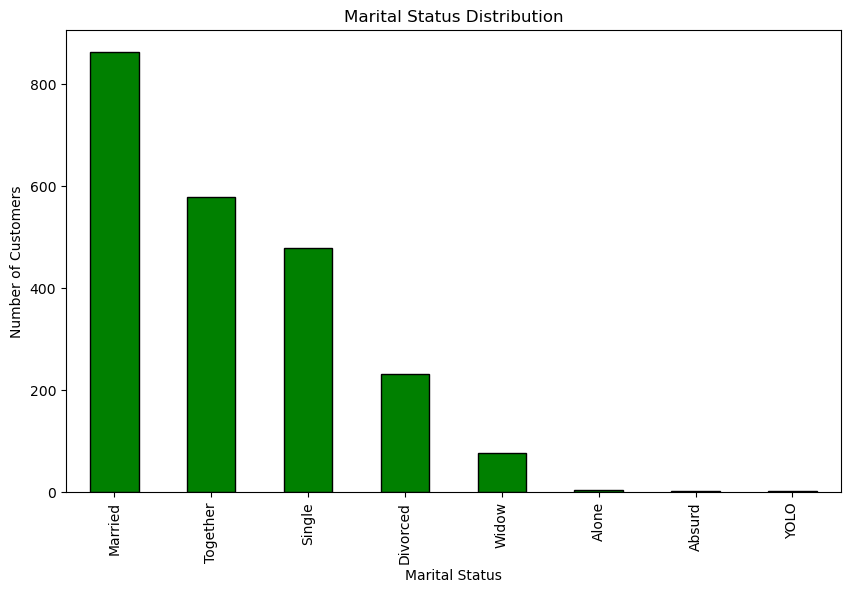

In [7]:
# Marital status distribution
plt.figure(figsize=(10, 6))
df_cleaned['Marital_Status'].value_counts().plot(kind='bar', color='green', edgecolor='black')
plt.title('Marital Status Distribution')
plt.xlabel('Marital Status')
plt.ylabel('Number of Customers')
plt.show()

## Household Structure Analysis

/var/folders/n3/wq3qj7vn3c12xjhrsq0nrmcr0000gn/T/ipykernel_16720/4093560133.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['TotalChildren'] = df_cleaned['Kidhome'] + df_cleaned['Teenhome']


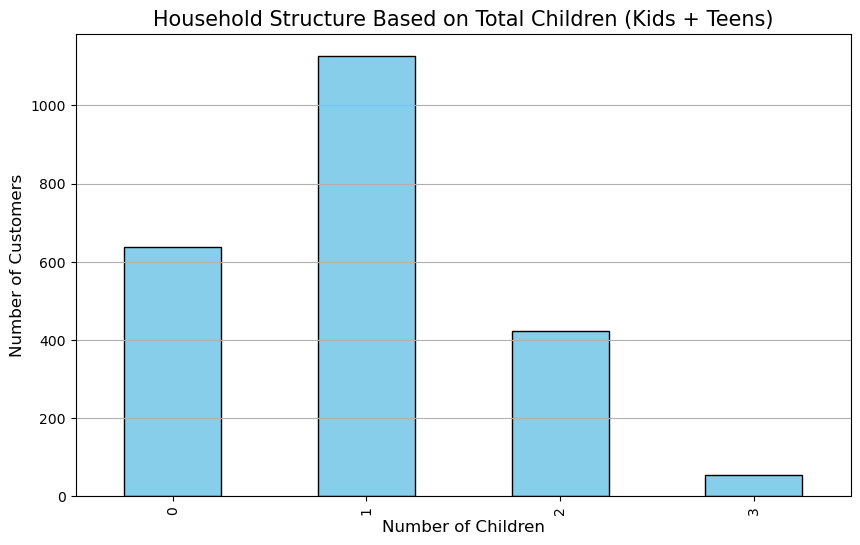

In [8]:
df_cleaned['TotalChildren'] = df_cleaned['Kidhome'] + df_cleaned['Teenhome']
plt.figure(figsize=(10, 6))
df_cleaned['TotalChildren'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Household Structure Based on Total Children (Kids + Teens)', fontsize=15)
plt.xlabel('Number of Children', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.grid(axis='y')
plt.show()

## Recency of Purchases Analysis

/var/folders/n3/wq3qj7vn3c12xjhrsq0nrmcr0000gn/T/ipykernel_16720/1540201559.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Recency_Segment'] = pd.cut(df_cleaned['Recency'], bins=[0, 30, 60, 90, 100], labels=["Active", "Recent", "Inactive", "Dormant"])


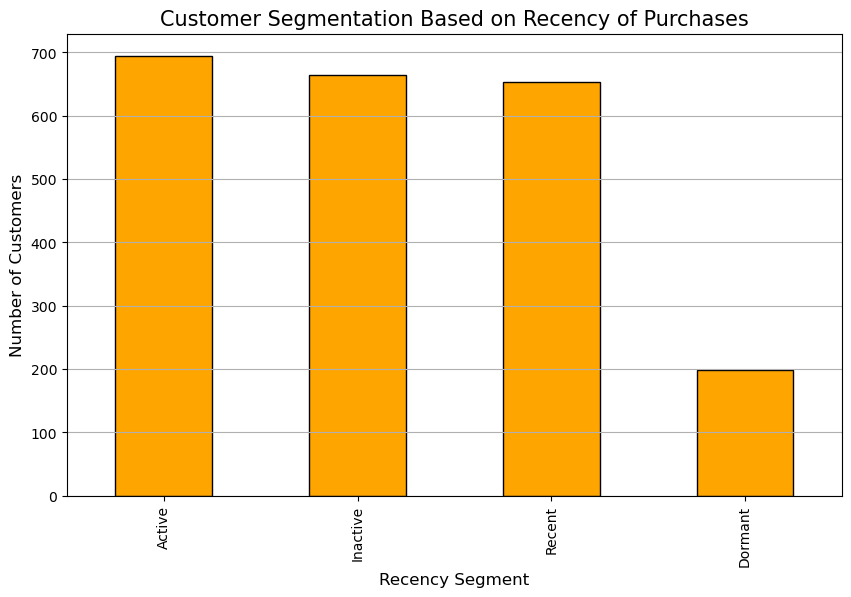

In [9]:
df_cleaned['Recency_Segment'] = pd.cut(df_cleaned['Recency'], bins=[0, 30, 60, 90, 100], labels=["Active", "Recent", "Inactive", "Dormant"])
plt.figure(figsize=(10, 6))
df_cleaned['Recency_Segment'].value_counts().plot(kind='bar', color='orange', edgecolor='black')
plt.title('Customer Segmentation Based on Recency of Purchases', fontsize=15)
plt.xlabel('Recency Segment', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.grid(axis='y')
plt.show()

## Spending Behavior Analysis

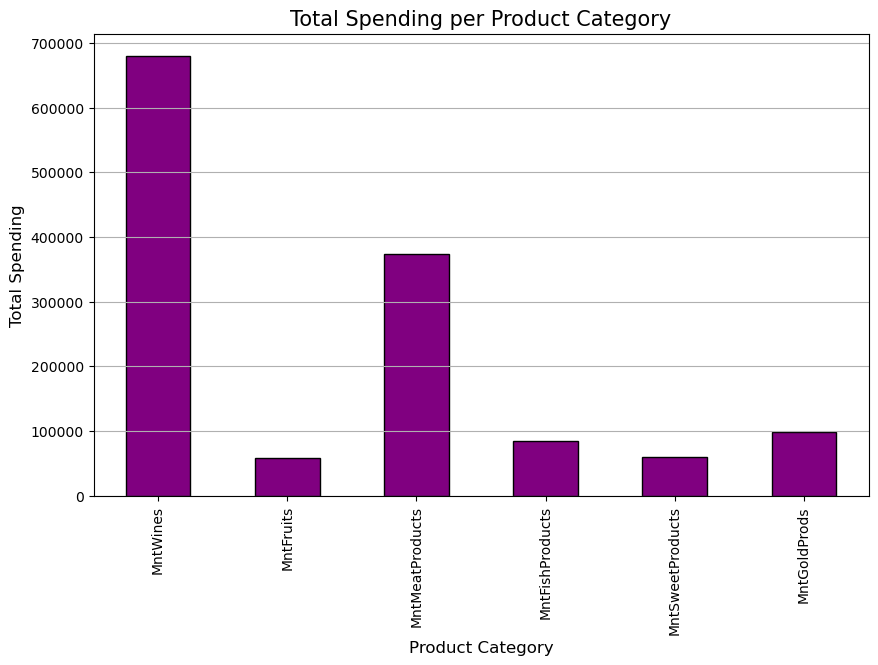

In [10]:
product_spending = df_cleaned[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum()
plt.figure(figsize=(10, 6))
product_spending.plot(kind='bar', color='purple', edgecolor='black')
plt.title('Total Spending per Product Category', fontsize=15)
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Total Spending', fontsize=12)
plt.grid(axis='y')
plt.show()

## Campaign Effectiveness

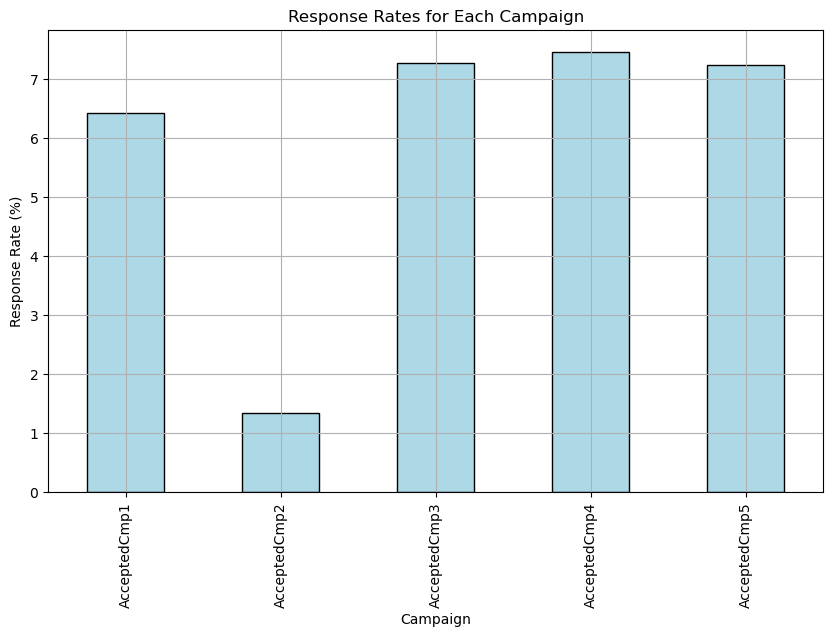

In [11]:
campaign_columns = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
response_rate = df_cleaned[campaign_columns].mean() * 100
plt.figure(figsize=(10, 6))
response_rate.plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Response Rates for Each Campaign')
plt.xlabel('Campaign')
plt.ylabel('Response Rate (%)')
plt.grid(True)
plt.show()

## Customer Engagement

/var/folders/n3/wq3qj7vn3c12xjhrsq0nrmcr0000gn/T/ipykernel_16720/383355730.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['AcceptedAnyCampaign'] = df_cleaned[campaign_columns].sum(axis=1) > 0


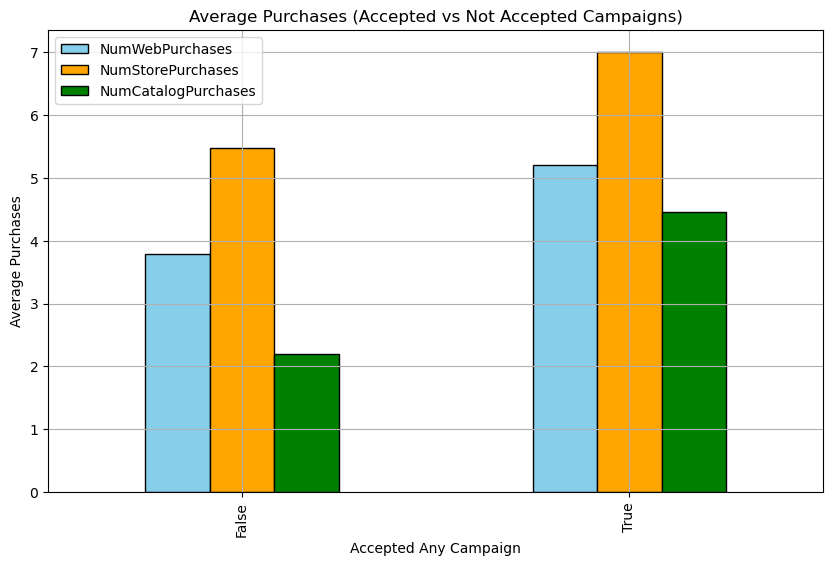

In [12]:
df_cleaned['AcceptedAnyCampaign'] = df_cleaned[campaign_columns].sum(axis=1) > 0
purchase_columns = ['NumWebPurchases', 'NumStorePurchases', 'NumCatalogPurchases']
engagement_comparison = df_cleaned.groupby('AcceptedAnyCampaign')[purchase_columns].mean()
engagement_comparison.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange', 'green'], edgecolor='black')
plt.title('Average Purchases (Accepted vs Not Accepted Campaigns)')
plt.xlabel('Accepted Any Campaign')
plt.ylabel('Average Purchases')
plt.grid(True)
plt.show()

## Revenue and Cost Efficiency

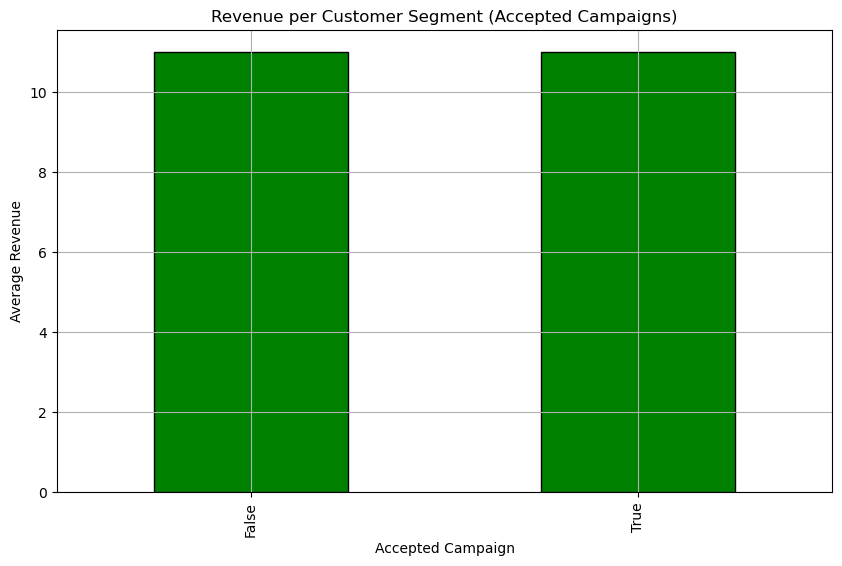

In [13]:
revenue_per_segment = df_cleaned.groupby('AcceptedAnyCampaign')['Z_Revenue'].mean()
plt.figure(figsize=(10, 6))
revenue_per_segment.plot(kind='bar', color='green', edgecolor='black')
plt.title('Revenue per Customer Segment (Accepted Campaigns)')
plt.xlabel('Accepted Campaign')
plt.ylabel('Average Revenue')
plt.grid(True)
plt.show()

## Cost of Customer Contact vs Revenue

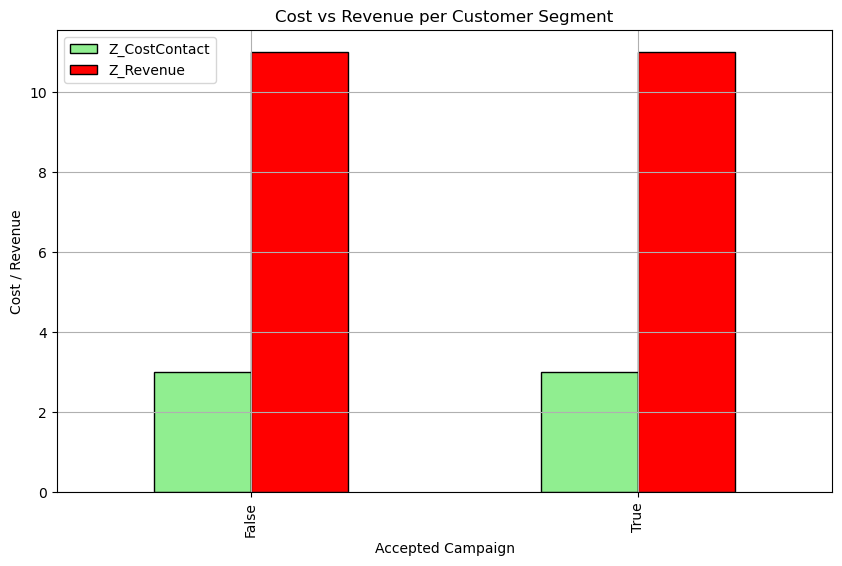

In [14]:
cost_vs_revenue = df_cleaned.groupby('AcceptedAnyCampaign')[['Z_CostContact', 'Z_Revenue']].mean()
cost_vs_revenue.plot(kind='bar', figsize=(10, 6), color=['lightgreen', 'red'], edgecolor='black')
plt.title('Cost vs Revenue per Customer Segment')
plt.xlabel('Accepted Campaign')
plt.ylabel('Cost / Revenue')
plt.grid(True)
plt.show()

## Web, Store, and Catalog Purchases

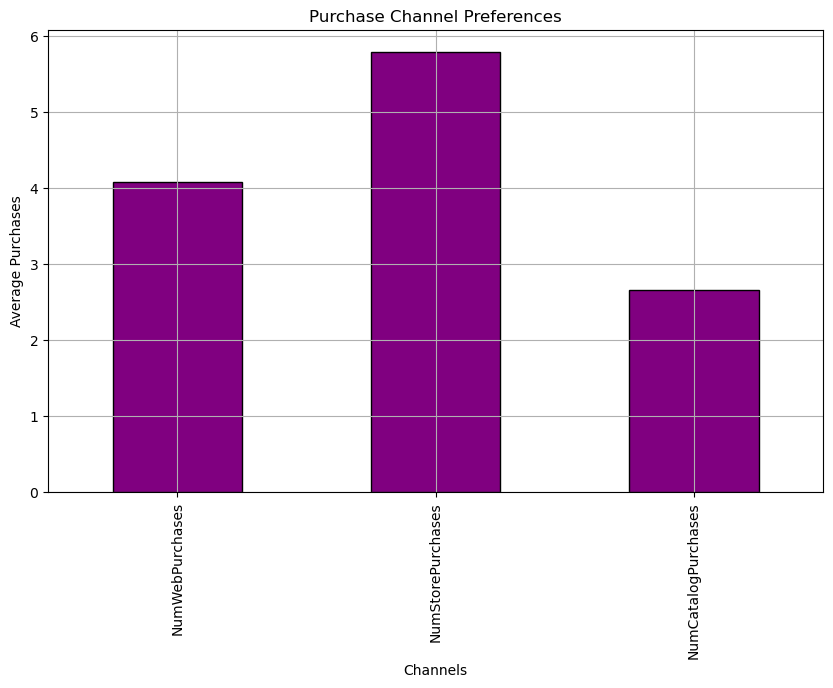

In [15]:
channel_preference = df_cleaned[['NumWebPurchases', 'NumStorePurchases', 'NumCatalogPurchases']].mean()
plt.figure(figsize=(10, 6))
channel_preference.plot(kind='bar', color='purple', edgecolor='black')
plt.title('Purchase Channel Preferences')
plt.xlabel('Channels')
plt.ylabel('Average Purchases')
plt.grid(True)
plt.show()

## Complaints Analysis

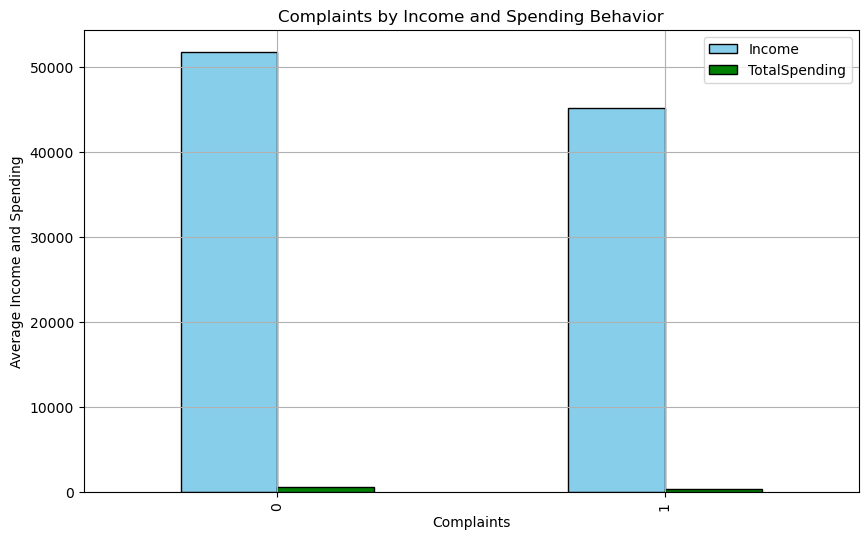

In [16]:
complaints_analysis = df_cleaned.groupby('Complain')[['Income', 'TotalSpending']].mean()
complaints_analysis.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'green'], edgecolor='black')
plt.title('Complaints by Income and Spending Behavior')
plt.xlabel('Complaints')
plt.ylabel('Average Income and Spending')
plt.grid(True)
plt.show()

## Spending Behavior Clustering


In [17]:
# Select spending-related features for clustering
spending_features = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

# Standardize the spending data
scaler = StandardScaler()
spending_scaled = scaler.fit_transform(df_cleaned[spending_features])

/Users/rafat/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/rafat/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/rafat/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/rafat/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/rafat/anacond

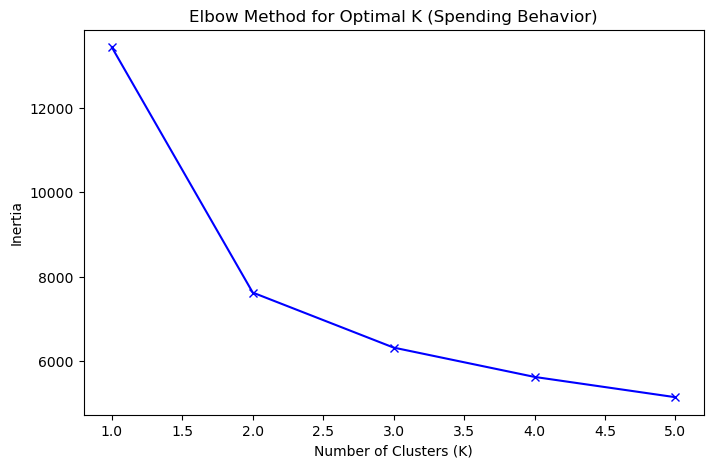

In [18]:
# Elbow Method to find the optimal number of clusters
inertia = []
K = range(1,6)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(spending_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K (Spending Behavior)')
plt.show()

In [19]:
# Apply K-Means clustering with the optimal number of clusters (assuming K=3)
kmeans = KMeans(n_clusters=3, random_state=42)
df_cleaned['SpendingCluster'] = kmeans.fit_predict(spending_scaled)

# Analyze the cluster centers
spending_cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=spending_features)
print("Spending Cluster Centers:")
spending_cluster_centers

Spending Cluster Centers:


/Users/rafat/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/n3/wq3qj7vn3c12xjhrsq0nrmcr0000gn/T/ipykernel_16720/1218303263.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['SpendingCluster'] = kmeans.fit_predict(spending_scaled)


,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
0,648.725490,31.511586,295.488414,44.928699,30.659537,73.475936
1,95.116208,6.413609,35.251529,9.029817,6.379205,18.581040
2,519.528455,88.634146,437.731707,127.181572,94.886179,89.048780


In [20]:
# Silhouette Score for the clustering
silhouette_avg = silhouette_score(spending_scaled, df_cleaned['SpendingCluster'])
print("Silhouette Score for Spending Behavior Clustering: ",silhouette_avg)


Silhouette Score for Spending Behavior Clustering:  0.45942024254843866


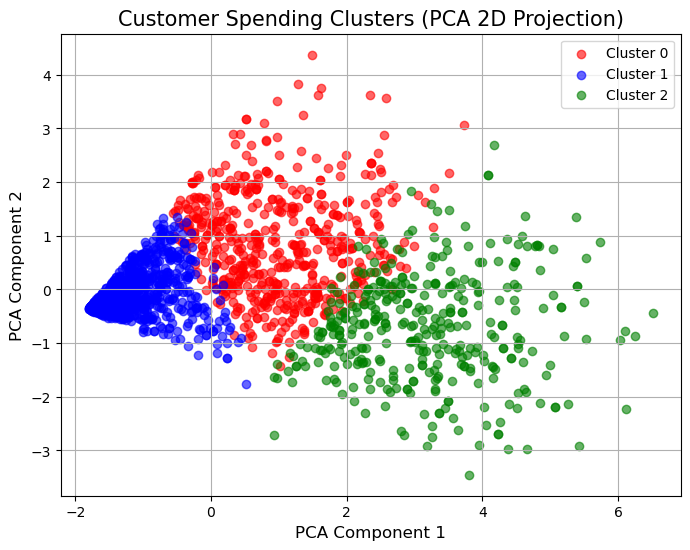

In [21]:
from sklearn.decomposition import PCA

# Step 1: Reduce the dimensions using PCA to 2 components
pca = PCA(n_components=2)
spending_pca = pca.fit_transform(spending_scaled)

# Step 2: Create a scatter plot of the clusters in the 2D PCA space
plt.figure(figsize=(8, 6))
plt.scatter(spending_pca[df_cleaned['SpendingCluster'] == 0, 0], spending_pca[df_cleaned['SpendingCluster'] == 0, 1], 
            c='red', label='Cluster 0', alpha=0.6)
plt.scatter(spending_pca[df_cleaned['SpendingCluster'] == 1, 0], spending_pca[df_cleaned['SpendingCluster'] == 1, 1], 
            c='blue', label='Cluster 1', alpha=0.6)
plt.scatter(spending_pca[df_cleaned['SpendingCluster'] == 2, 0], spending_pca[df_cleaned['SpendingCluster'] == 2, 1], 
            c='green', label='Cluster 2', alpha=0.6)

# Step 3: Plot configuration
plt.title('Customer Spending Clusters (PCA 2D Projection)', fontsize=15)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()
